In [20]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import argparse
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.contrib.slim as slim

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from scipy.stats import pearsonr

import data_input_jpg as dataset

## Evaluation Configurations

In [54]:
# import vgg_deep_combo as vgg
# import vgg_shallow_combo as vgg
from tensorflow.contrib.slim.python.slim.nets import vgg
ISCOMBO = False
# ANNOS_CSV = '/home/timhu/data/state24_jpgpaths_clean_17k_May17.csv'
ANNOS_CSV = '/home/timhu/data/all_jpgpaths_clean_538k_May17.csv'
DATA = 's1' #l8s1, l8, s1
JPG_DIR = '/home/timhu/data/all_jpg/'
LOG_DIR = '/home/timhu/logs/regression_s1_allstate_lr-5_decay-1_wd5e-3_drop08_vgg_Jul28'
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224
IMAGE_CHANNEL = 3
FLAGS = argparse.Namespace(dropout_keep= 0.8,
                           batch_size= 1, # for eval, go through one by one
                           output_size = 1) # embedding size or class number 

In [55]:
# find model checkpoint
ckpt_state = tf.train.get_checkpoint_state(LOG_DIR)
if ckpt_state and ckpt_state.model_checkpoint_path:
    CKPT = ckpt_state.model_checkpoint_path
    print('Lastest checkpoint:', CKPT)
else:
    print("ckpt doesn't exists at:", LOG_DIR)

Lastest checkpoint: /home/timhu/logs/regression_s1_allstate_lr-5_decay-1_wd5e-3_drop08_vgg_Jul28/model.ckpt-144400


## Data/Model Loading

In [56]:
# load annotation CSV
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)
df_annos.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
535128,567631,34,637,5915,6737,6049.450048,4.667680e+06,79.792090,10.923974,1443.329506,10.495185,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535129,567632,34,637,5915,2260,2035.500015,4.514581e+06,79.757279,10.921364,500.600113,8.967515,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535130,567633,34,637,5915,3942,3527.600028,5.891136e+06,79.742833,10.931922,669.140890,9.386166,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535131,567634,34,637,5915,2521,2269.200016,3.121377e+06,79.771553,10.917816,807.656442,9.657598,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535132,567635,34,637,5915,3197,2873.100021,4.717539e+06,79.793871,10.908532,677.683821,9.404469,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...


In [57]:
# load input image file, labels, village_ids, for model inference
if DATA == 'l8':
    path_col = ['l8_vis_jpg']
elif DATA == 's1':
    path_col = ['s1_vis_jpg']
elif DATA == 'l8s1':
    path_col = ['l8_vis_jpg', 's1_vis_jpg']
input_files_test = JPG_DIR + df_annos.loc[df_annos.partition == 'test', path_col].values
input_labels_test = df_annos.loc[df_annos.partition == 'test', 'pop_density_log2'].values
input_id_test = df_annos.loc[df_annos.partition == 'test', 'village_id'].values
test_size = len(input_id_test)
print('total number of test images:', test_size)

total number of test images: 57567


In [58]:
#setup predition results table: 
# village_id, state_id, district_id, subdistrict_id, pop, log_pop, predict_pop, predict_log2_pop
df_test = df_annos[df_annos.partition == 'test']
df_test = df_test[['village_id','state_id','district_id','subdistrict_id','area', 'secc_pop', 'pop_density','pop_density_log2']]
df_test.area = df_test.area / 1e6 # convert area from m2 to km2
df_test.tail()

,village_id,state_id,district_id,subdistrict_id,area,secc_pop,pop_density,pop_density_log2
534250,566741,33,631,5891,9.387259,2774,295.506926,8.207048
534251,566742,33,631,5891,14.659993,6138,418.690507,8.709740
534252,566743,33,631,5891,12.207912,5827,477.313385,8.898793
534253,566744,33,631,5891,14.200096,4543,319.927418,8.321601
534254,566745,33,631,5891,13.059874,3564,272.896967,8.092213


In [59]:
tf.reset_default_graph()
sess = tf.Session()
with tf.device('/cpu:0'):
    test_images_batch, test_labels_batch, test_ids_batch = dataset.input_batches(
        FLAGS.batch_size, FLAGS.output_size, input_files_test, input_labels_test, input_id_test,
        IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, regression=True, augmentation=False, normalization=True)

if ISCOMBO:
    images_l8_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3]) 
    images_s1_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
else:
    images_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
labels_placeholder = tf.placeholder(tf.float32, shape=[None,])

test_batches = int(test_size / FLAGS.batch_size) # number of training batches/steps in each epoch

with slim.arg_scope(vgg.vgg_arg_scope()):
    if ISCOMBO:
        outputs, _ = vgg.vgg_16(images_l8_placeholder, images_s1_placeholder, num_classes=FLAGS.output_size, 
                               dropout_keep_prob=FLAGS.dropout_keep, is_training=False)
    else:
        outputs, _ = vgg.vgg_16(images_placeholder, num_classes=FLAGS.output_size, 
                                   dropout_keep_prob=FLAGS.dropout_keep, is_training=False)
    outputs = tf.squeeze(outputs)

init = tf.global_variables_initializer()
sess.run(init)
restorer = tf.train.Saver()
restorer.restore(sess, CKPT)

INFO:tensorflow:Restoring parameters from /home/timhu/logs/regression_s1_allstate_lr-5_decay-1_wd5e-3_drop08_vgg_Jul28/model.ckpt-144400


## Model Inference (by default batch_size = 1)

In [60]:
infe_log2_out = []
infe_ids = []

for step in range(test_batches):
    if  step % 1000 == 0:
        print('finish batches:', step)
    images_out, labels_out, ids_out = sess.run([test_images_batch, test_labels_batch, test_ids_batch])
    if ISCOMBO:
        feed_dict = {images_l8_placeholder: images_out[:,:,:,:3],images_s1_placeholder: images_out[:,:,:,3:],
                     labels_placeholder: labels_out}
    else:
        feed_dict = {images_placeholder: images_out, labels_placeholder: labels_out}
    
    log2_out = sess.run(outputs, feed_dict = feed_dict)
    infe_log2_out.append(log2_out)
    infe_ids.append(ids_out[0])

finish batches: 0
finish batches: 1000
finish batches: 2000
finish batches: 3000
finish batches: 4000
finish batches: 5000
finish batches: 6000
finish batches: 7000
finish batches: 8000
finish batches: 9000
finish batches: 10000
finish batches: 11000
finish batches: 12000
finish batches: 13000
finish batches: 14000
finish batches: 15000
finish batches: 16000
finish batches: 17000
finish batches: 18000
finish batches: 19000
finish batches: 20000
finish batches: 21000
finish batches: 22000
finish batches: 23000
finish batches: 24000
finish batches: 25000
finish batches: 26000
finish batches: 27000
finish batches: 28000
finish batches: 29000
finish batches: 30000
finish batches: 31000
finish batches: 32000
finish batches: 33000
finish batches: 34000
finish batches: 35000
finish batches: 36000
finish batches: 37000
finish batches: 38000
finish batches: 39000
finish batches: 40000
finish batches: 41000
finish batches: 42000
finish batches: 43000
finish batches: 44000
finish batches: 45000
f

In [61]:
# merge inference results with prediction table 
df_pred = pd.DataFrame({'village_id': infe_ids, 'pred_log2_density': infe_log2_out})
df_res = pd.merge(df_test, df_pred, on='village_id', how = 'left')
df_res['pre_density'] = 2 ** df_res.pred_log2_density
df_res.head()

,village_id,state_id,district_id,subdistrict_id,area,secc_pop,pop_density,pop_density_log2,pred_log2_density,pre_density
0,1247,1,6,22,5.935085,1110,187.023443,7.547075,6.276467,77.518423
1,1248,1,6,22,3.630205,865,238.278585,7.896505,8.249425,304.315695
2,1249,1,6,22,13.779807,2715,197.027428,7.622253,7.815900,225.330665
3,1250,1,6,22,11.077119,2142,193.371573,7.595232,6.405879,84.793310
4,1251,1,6,22,15.071663,5688,377.396982,8.559939,5.651179,50.254445


In [62]:
df_res.to_csv(LOG_DIR + '.csv')

## Evaluation Plots/Stats

### 1. Direct Sum Aggregation comparison

In [63]:
df_direct_log2_sum = df_res.groupby('subdistrict_id')['pop_density_log2', 'pred_log2_density'].agg(np.sum)
true_subdistrict_vals = df_direct_log2_sum.pop_density_log2.values
pred_subdistrict_vals = df_direct_log2_sum.pred_log2_density.values

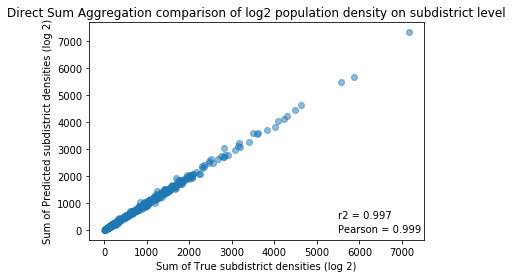

In [64]:
plt.title("Direct Sum Aggregation comparison of log2 population density on subdistrict level")
plt.ylabel("Sum of Predicted subdistrict densities (log 2)")
plt.xlabel("Sum of True subdistrict densities (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

This uses the same methods as the plot shown in the presentation at the end of quarter. The comparison of population density between predition and ground-truth is on subdistrict level, and taking the direct sum of each log2 density value from each subdistrict. It might not be a valid comparison, because each village has log2 density in a very small range (6-9), the values on subdistricts level are quite depend on the number of villages within it. With more villages in one subdistrict, the aggregated log2 value would increase proportionaly. 

It would be better to compare the average population density on subdistricts.

### 2. Direct Average Aggregation comparison

In [65]:
df_direct_log2_ave = df_res.groupby('subdistrict_id')['pop_density_log2', 'pred_log2_density'].agg(np.mean)
true_subdistrict_vals = df_direct_log2_ave.pop_density_log2.values
pred_subdistrict_vals = df_direct_log2_ave.pred_log2_density.values

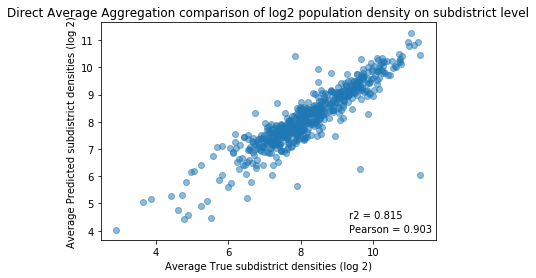

In [66]:
plt.title("Direct Average Aggregation comparison of log2 population density on subdistrict level")
plt.ylabel("Average Predicted subdistrict densities (log 2)")
plt.xlabel("Average True subdistrict densities (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

### 3. Weighted Average Aggregation comparison

In [67]:
df_res['pred_pop'] = df_res.pre_density * df_res.area
df_weighted_sum = df_res.groupby('subdistrict_id')['secc_pop', 'pred_pop','area'].agg(np.sum)
df_weighted_sum['secc_pop_density'] = df_weighted_sum.secc_pop / df_weighted_sum.area
df_weighted_sum['pred_pop_density'] = df_weighted_sum.pred_pop / df_weighted_sum.area
df_weighted_sum['secc_pop_density_log2'] = np.log2(df_weighted_sum.secc_pop_density)
df_weighted_sum['pred_pop_density_log2'] = np.log2(df_weighted_sum.pred_pop_density)
df_weighted_sum.head()

,secc_pop,pred_pop,area,secc_pop_density,pred_pop_density,secc_pop_density_log2,pred_pop_density_log2
subdistrict_id,,,,,,,
22,161483,99418.759460,510.430255,316.366435,194.774425,8.305453,7.605660
26,60141,50156.220329,325.216946,184.925788,154.223884,7.530803,7.268882
34,148108,164932.248949,191.257845,774.389148,862.355469,9.596915,9.752139
37,62879,60357.295411,181.121729,347.164309,333.241603,8.439475,8.380425
40,44164,5355.994594,60.718620,727.355140,88.210085,9.506516,6.462872


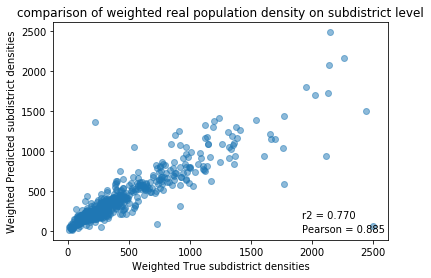

In [68]:
true_subdistrict_vals = df_weighted_sum.secc_pop_density.values
pred_subdistrict_vals = df_weighted_sum.pred_pop_density.values

plt.title("comparison of weighted real population density on subdistrict level")
plt.ylabel("Weighted Predicted subdistrict densities")
plt.xlabel("Weighted True subdistrict densities")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

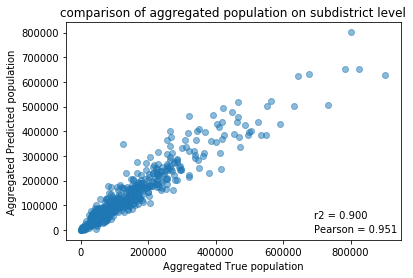

In [69]:
true_subdistrict_vals = df_weighted_sum.secc_pop.values
pred_subdistrict_vals = df_weighted_sum.pred_pop.values

plt.title("comparison of aggregated population on subdistrict level")
plt.ylabel("Aggregated Predicted population")
plt.xlabel("Aggregated True population")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)

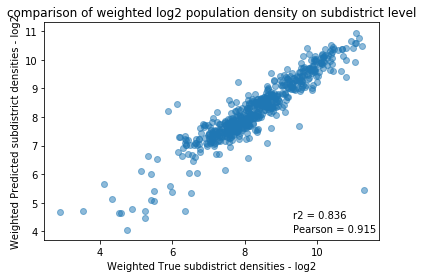

In [37]:
true_subdistrict_vals = df_weighted_sum.secc_pop_density_log2.values
pred_subdistrict_vals = df_weighted_sum.pred_pop_density_log2.values

plt.title("comparison of weighted log2 population density on subdistrict level")
plt.ylabel("Weighted Predicted subdistrict densities - log2")
plt.xlabel("Weighted True subdistrict densities - log2")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)